# Análisis Exploratorio de Imágenes (EDA)

En esta sección se lleva a cabo un análisis exploratorio de las imágenes proporcionadas por el dataset ODIR-5K, cuyo objetivo principal es la detección automática de patologías oculares mediante aprendizaje profundo. El conjunto de datos incluye imágenes de fondo de ojo (retinografías) correspondientes a ambos ojos (izquierdo y derecho) de cada paciente, junto con sus respectivas etiquetas diagnósticas:

    - Normal (N)
    - Diabetes (D)
    - Glaucoma (G)
    - Cataract (C)
    - Age related Macular Degeneration (A)
    - Hypertension (H)
    - Pathological Myopia (M)
    - Other diseases/abnormalities (O)

El propósito de este análisis es examinar la estructura, calidad y disponibilidad de las imágenes, así como identificar posibles inconsistencias, variaciones en el tamaño o el formato, diferencias de contraste o brillo, y cualquier otra característica relevante que pueda impactar en la fase de preprocesamiento y entrenamiento del modelo.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os 
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from scipy.stats import ttest_ind

### Carga y vista general dataset
En este apartado se realiza la carga inicial del dataset ODIR-5K y una exploración básica de su contenido.

In [2]:
# Carga del dataset
df = pd.read_csv("../full_df.csv")

# Dimendión y primeras filas del dataset
print("Dataset shape:", df.shape)
df.head(10)

Dataset shape: (6392, 19)


ID  Patient Age Patient Sex  Left-Fundus  Right-Fundus  \
0   0           69      Female   0_left.jpg   0_right.jpg   
1   1           57        Male   1_left.jpg   1_right.jpg   
2   2           42        Male   2_left.jpg   2_right.jpg   
3   4           53        Male   4_left.jpg   4_right.jpg   
4   5           50      Female   5_left.jpg   5_right.jpg   
5   6           60        Male   6_left.jpg   6_right.jpg   
6   7           60      Female   7_left.jpg   7_right.jpg   
7   8           59        Male   8_left.jpg   8_right.jpg   
8   9           54        Male   9_left.jpg   9_right.jpg   
9  10           70        Male  10_left.jpg  10_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   
5                        macular epiretinal membrane   
6                                             drusen   
7                                      normal fundus   
8                                      normal fundus   
9                                epiretinal membrane   

                           Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                                      normal fundus  0  0  0  1  0  0  0  0   
1                                      normal fundus  1  0  0  0  0  0  0  0   
2             moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4             moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   
5  moderate non proliferative retinopathy，epireti...  0  1  0  0  0  0  0  1   
6                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
7                                      normal fundus  1  0  0  0  0  0  0  0   
8                              vitreous degeneration  0  0  0  0  0  0  0  1   
9                                      normal fundus  0  0  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
5  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
6  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
7  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
8  ../input/ocular-disease-recognition-odir5k/ODI...  ['O']   
9  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   

                     target      filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]   0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]   1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]   2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]   4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]   5_right.jpg  
5  [0, 1, 0, 0, 0, 0, 0, 0]   6_right.jpg  
6  [0, 1, 0, 0, 0, 0, 0, 0]   7_right.jpg  
7  [1, 0, 0, 0, 0, 0, 0, 0]   8_right.jpg  
8  [0, 0, 0, 0, 0, 0, 0, 1]   9_right.jpg  
9  [1, 0, 0, 0, 0, 0, 0, 0]  10_right.jpg

In [3]:
# Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [4]:
# Conteo total de IDs únicos vs total filas
total_rows = df.shape[0]
unique_ids = df['ID'].nunique()

print(f"Número total de filas: {total_rows}")
print(f"IDs únicos por paciente: {unique_ids}")

Número total de filas: 6392
IDs únicos por paciente: 3358


In [5]:
# Agrupar por ID y contar cuántas imágenes diferentes hay por paciente
df['eye_side'] = df['filename'].apply(lambda x: 'left' if 'left' in x else 'right')
eye_counts = df.groupby('ID')['eye_side'].nunique()

# Ver pacientes con una sola imagen
missing_eye = eye_counts[eye_counts < 2]

print(f"Número de pacientes con una sola imagen: {len(missing_eye)}")

Número de pacientes con una sola imagen: 324


Algunos pacientes (324) solo disponen de una imagen de un ojo (ya sea el izquierdo o el derecho).

### Análisis estructural de las imégens

En esta sección se analizá las dimensiones (alto, ancho y número de canales) de las imágenes del dataset, así como la orientación de las mismas, y detección de imágenes corruptas. Este análisis permite identificar la variedad de tamaños presentes, detectar posibles inconsistencias y establecer criterios adecuados para el preprocesamiento y la normalización de las imágenes antes del entrenamiento del modelo.


In [6]:
# Ruta de las imágenes
image_dir = "../ODIR-5K/ODIR-5K/Training Images"

In [7]:
# Función para obtener las dimensiones de las imágenes y detectar archivos corruptos
def get_image_sizes(image_paths):
    """
    Analiza las rutas de los archivos de imagen para extraer sus dimensiones e identificar imágenes corruptas.

    Parámetros:
        image_paths (lista de str): Lista de rutas completas a los archivos de imagen.

    Devuelve:
        size_counts: Tamaños de imagen (H, W, C) como claves y su frecuencia como valores.
        corrupted: Lista de rutas de archivos correspondientes a imágenes que no se pudieron leer.
    """
    sizes = []
    corrupted = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            sizes.append((h, w, c))
        else:
            corrupted.append(path)

    size_counts = Counter(sizes)
    return size_counts, corrupted

Vemos los 15 tamaños de imagen más comunes y el número total de imágenes corruptas identificadas.

In [8]:
# Construir las rutas completas de las imágenes
image_paths = df['filename'].apply(lambda x: os.path.join(image_dir, x)).tolist()

# Obtener los tamaños de las imágenes y detectar las corruptas
size_counts, corrupted_images = get_image_sizes(image_paths)

# Mostrar los 15 tamaños de imagen más comunes
print("Tamaños de imagen más comunes:\n")
for size, count in size_counts.most_common(15):
    print(f"{size}: {count} imágenes")

# Mostrar imágenes corruptas
print(f"\nNúmero de imágenes corruptas: {len(corrupted_images)}")

Tamaños de imagen más comunes:

(1728, 2592, 3): 1982 imágenes
(1536, 2048, 3): 489 imágenes
(1728, 2304, 3): 392 imágenes
(1934, 1956, 3): 379 imágenes
(1824, 2736, 3): 325 imágenes
(1444, 1444, 3): 254 imágenes
(2304, 3456, 3): 243 imágenes
(1984, 2976, 3): 206 imágenes
(1296, 1936, 3): 198 imágenes
(1152, 1536, 3): 192 imágenes
(2448, 3264, 3): 166 imágenes
(2056, 2124, 3): 144 imágenes
(2592, 3888, 3): 121 imágenes
(2976, 2976, 3): 118 imágenes
(2000, 2584, 3): 103 imágenes

Número de imágenes corruptas: 0


Se observa que las imágenes presentan una notable variabilidad en sus dimensiones, con más de 15 tamaños diferentes. El formato más frecuente es (1728, 2592, 3), presente en 1.982 imágenes, seguido por otras resoluciones como (1536, 2048, 3) y (1728, 2304, 3). Será necesario aplicar un proceso de redimensionado uniforme durante el preprocesamiento.

Esto permitirá:

- Establecer una entrada consistente para el modelo (por ejemplo, redes convolucionales como ResNet o EfficientNet requieren una resolución fija).

- Aumentar la eficiencia computacional al reducir el tamaño de las imágenes más grandes.

- Evitar errores o inconsistencias en los DataLoaders si se trabaja con batches de imágenes.

Por otro lado, no se han identificado imágenes corruptas, lo que confirma que todos los archivos pueden ser leídos correctamente y están disponibles para su procesamiento posterior.

In [9]:
# Muestra una selección aleatoria de imágenes 
def show_random_images(df, image_dir, n=15):
    """
    Muestra una selección aleatoria de imágenes del conjunto de datos.

    Parámetros:
        df: DataFrame que contiene los nombres de archivo de las imágenes.
        image_dir (str): Directorio donde se almacenan las imágenes.
        n (int): Número de imágenes a mostrar.
    """
    sample = df.sample(n)

    cols = 5
    rows = n // cols + 1 

    plt.figure(figsize=(15, 3 * rows))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        path = image_dir + "/" + sample.iloc[i]['filename']
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(sample.iloc[i]['filename'])

    plt.tight_layout()
    plt.show()

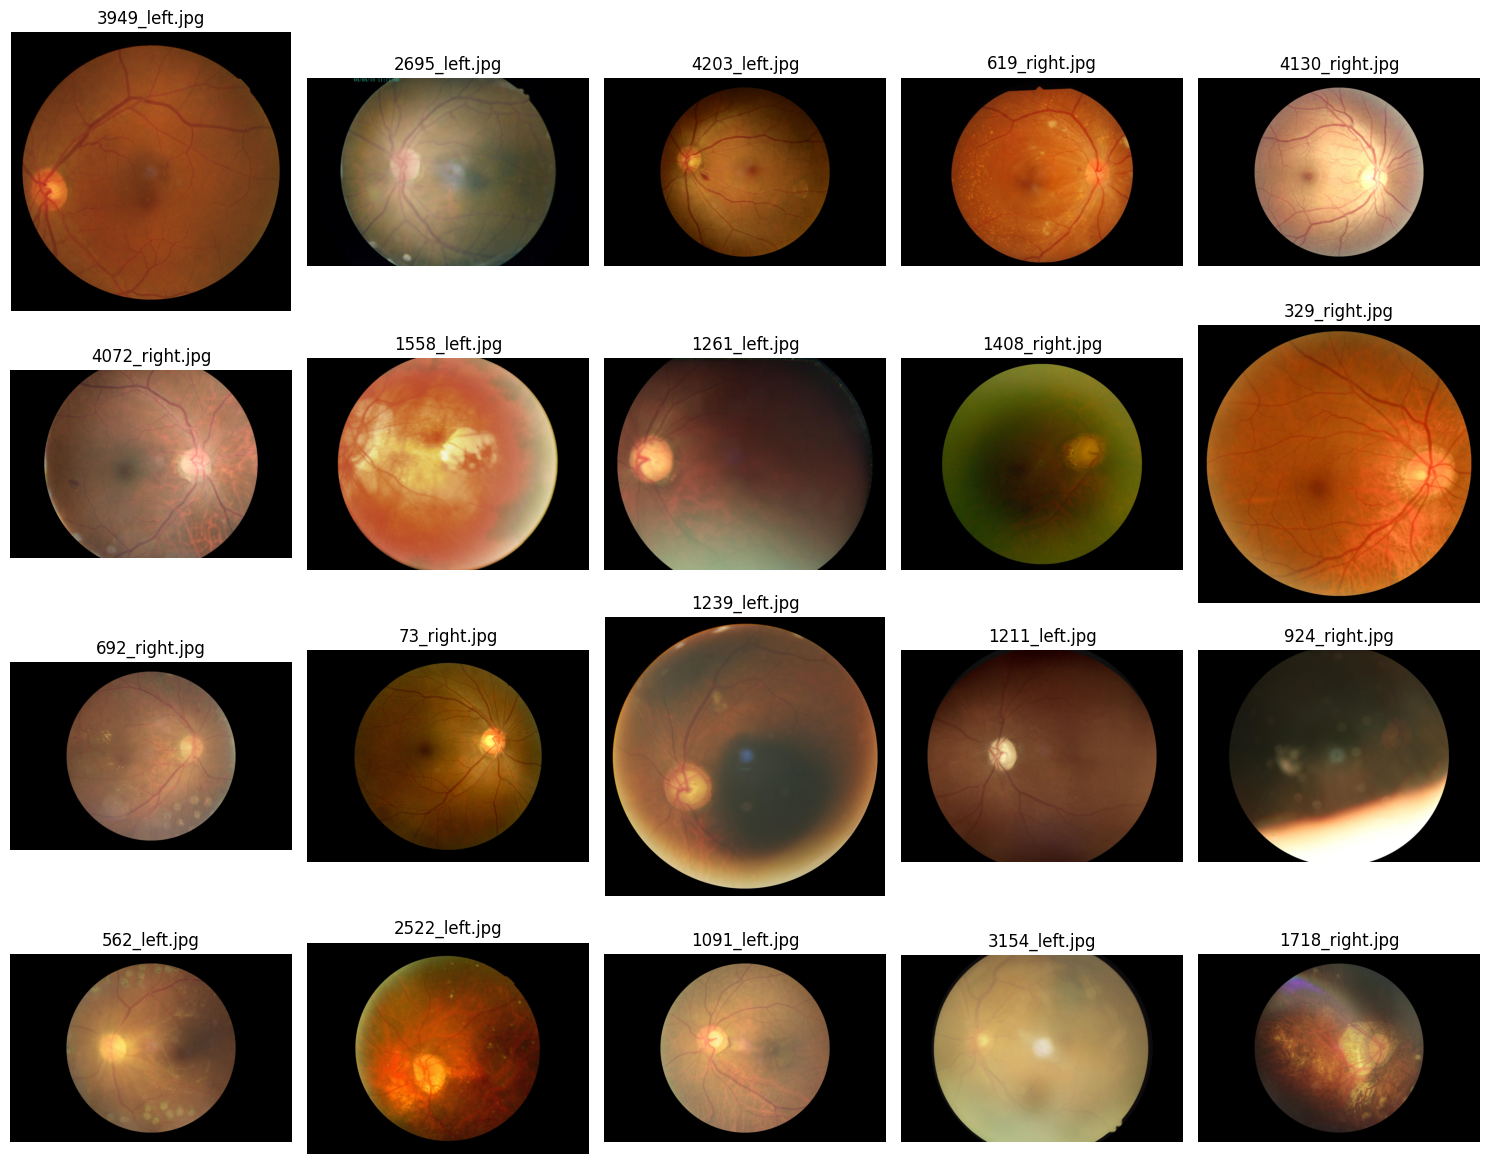

In [10]:
show_random_images(df, image_dir, n=20)

Se observa una variabilidad en la orientación de las imágenes: en algunas, la mácula aparece a la izquierda y en otras a la derecha, y también hay rotaciones leves debidas a diferencias en la captura.
Para que el modelo no dependa de la posición anatómica exacta y pueda generalizar mejor, podríamos aplicar en el preprocesado:

`RandomHorizontalFlip()` para compensar la simetría entre ojos.

`RandomRotation()` para simular variaciones reales de inclinación.

In [11]:
# Preparacion de DataFrames para visualizacion 
df_shapes = pd.DataFrame(size_counts.items(), columns=['tamaño', 'total'])
df_shapes = df_shapes.sort_values('total', ascending=False).reset_index(drop=True)

# Añadir columna de frecuencia acumulada
df_shapes['acumulado'] = df_shapes['total'].cumsum()

df_shapes

tamaño  total  acumulado
0   (1728, 2592, 3)   1982       1982
1   (1536, 2048, 3)    489       2471
2   (1728, 2304, 3)    392       2863
3   (1934, 1956, 3)    379       3242
4   (1824, 2736, 3)    325       3567
..              ...    ...        ...
92    (718, 770, 3)      1       6388
93    (783, 960, 3)      1       6389
94    (705, 758, 3)      1       6390
95    (805, 924, 3)      1       6391
96    (784, 949, 3)      1       6392

[97 rows x 3 columns]

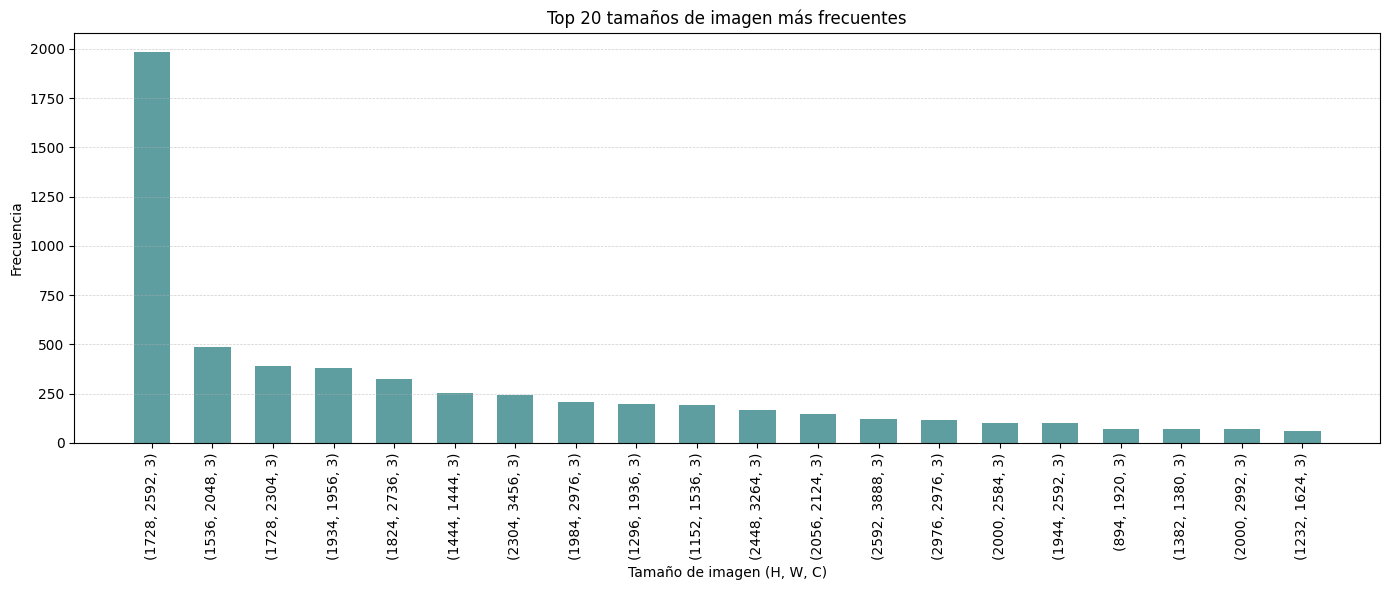

In [12]:
# Visualización de la distribución de los tamaños de imagen más comunes
# Ordenar por frecuencia descendente 
df_shapes = df_shapes.sort_values(by='total', ascending=False)

# filtrar los tamaños más frecuentes 
top_n = 20
df_cut = df_shapes.head(top_n)

# crear figura
plt.figure(figsize=(14, 6))

# Etiquetas de tamaños (H, W, C)
x_labels = [str(shape) for shape in df_cut['tamaño']]
x = range(len(df_cut))

# Gráfico de barras
plt.bar(x, df_cut['total'], width=0.6, color='cadetblue')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# Personalización del gráfico
plt.xticks(x, x_labels, rotation=90)
plt.xlabel("Tamaño de imagen (H, W, C)")
plt.ylabel("Frecuencia")
plt.title(f"Top {top_n} tamaños de imagen más frecuentes")
plt.tight_layout()

plt.show()

### Análisis de color de las imágenes

Se procede a evaluar posibles variaciones en el brillo, contraste y distribución del color, con el objetivo de considerar su impacto en las etapas posteriores de preprocesamiento, especialmente en lo relativo a la normalización y la aplicación de técnicas de data augmentation.

Por ejemplo, en el contexto de la detección de retinopatía diabética y edema macular diabético, resulta especialmente relevante la información contenida en los canales rojo y verde, ya que permiten identificar con mayor precisión signos clínicos como microhemorragias y exudados.

Se analiza en primer lugar los grises para detectar sobreeexposicion , contraste y dominancia de fondos negros. 

In [13]:
# Histograma normalizado de niveles de gris (%)
def compute_grayscale_histogram(image_path):
    """
    Calcula el histograma promedio normalizado (en %) de niveles de gris
    a partir de una lista de rutas a imágenes.

    Parámetros:
        image_path (list of str): Lista de rutas a archivos de imagen (.jpg, .png, etc.).

    Devuelve:
        hist_total (np.ndarray): Histograma promedio de intensidad en escala de grises,
            normalizado como porcentaje (256 valores).
        num_validas (int): Número de imágenes válidas procesadas.
    """
    hist_total = np.zeros(256)
    valid_img = 0

    for path in image_path:
        img = cv2.imread(path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
        hist_total += hist
        valid_img += 1

    if hist_total.sum() > 0:
        hist_total = (hist_total / hist_total.sum()) * 100  # Convertir a porcentaje

    return hist_total, valid_img

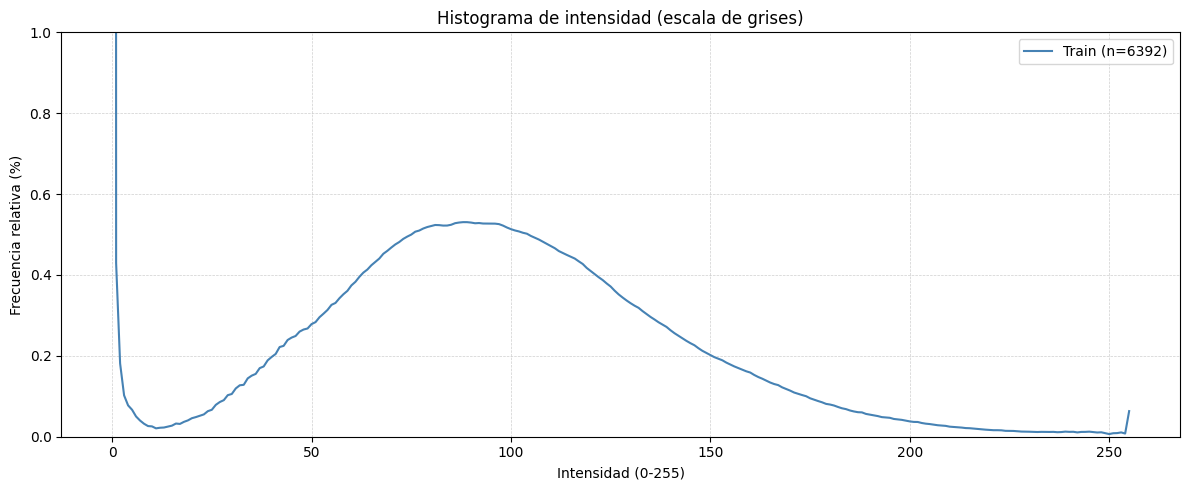

In [14]:
# Aplicamos la función al conjunto de imágenes
hist_grey, num_img = compute_grayscale_histogram(image_paths)

# Visualización del histograma promedio de niveles de gris
plt.figure(figsize=(12, 5))
plt.plot(hist_grey, label=f'Train (n={num_img})', color='steelblue')
plt.title("Histograma de intensidad (escala de grises)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Las intensidades medias, comprendidas aproximadamente entre los valores 50 y 150, suelen corresponder a la región central del fondo de ojo (retina), donde se concentra la mayor parte de la información clínica relevante. Por el contrario, las intensidades más bajas están asociadas a áreas periféricas oscuras o al fondo negro de la imagen, las cuales carecen de valor diagnóstico.

Con el objetivo de resaltar las estructuras anatómicas relevantes y mejorar el contraste entre regiones informativas y no informativas, se podría valorar aplicar la transformación `ColorJitter()` durante la fase de preprocesamiento. Esta técnica permite ajustar de forma aleatoria parámetros como el brillo, el contraste y la saturación, lo cual puede facilitar la detección de las diferentes patologías.

A continuación, se lleva a cabo el análisis de los canales de color Rojo, Verde y Azul (RGB) para examinar la distribución de intensidades y posibles desequilibrios cromáticos en las imágenes.

In [15]:
# Análisis promedio de histograma por canal RGB en imágenes
def compute_rgb_histogram(image_path):
    """
    Calcula el histograma promedio de los canales RGB (Rojo, Verde y Azul) 
    a partir de una lista de imágenes.

    Parámetros:
        image_paths (list of str): Rutas de las imágenes en formato .jpg.

    Devuelve:
        b_hist, g_hist, r_hist (np.ndarray): Histogramas promedio de los canales Azul, Verde y Rojo.
    """

    b_hist = np.zeros(256)
    g_hist = np.zeros(256)
    r_hist = np.zeros(256)

    for path in tqdm(image_path):
        img = cv2.imread(path)
        if img is None:
            continue

        b_channel = img[:, :, 0]
        g_channel = img[:, :, 1]
        r_channel = img[:, :, 2]

        b_hist += cv2.calcHist([b_channel], [0], None, [256], [0, 256]).ravel()
        g_hist += cv2.calcHist([g_channel], [0], None, [256], [0, 256]).ravel()
        r_hist += cv2.calcHist([r_channel], [0], None, [256], [0, 256]).ravel()

    # Promedio (evita división por 0 si hay imágenes nulas)
    num_valid_images = len([p for p in image_path if cv2.imread(p) is not None])
    if num_valid_images > 0:
        b_hist /= num_valid_images
        g_hist /= num_valid_images
        r_hist /= num_valid_images

    return b_hist, g_hist, r_hist


In [16]:
# Cálculo de histogramas RGB para las imágenes del dataset
image_b_hist, image_g_hist, image_r_hist = compute_rgb_histogram(image_paths)

100%|██████████| 6392/6392 [02:52<00:00, 37.11it/s]


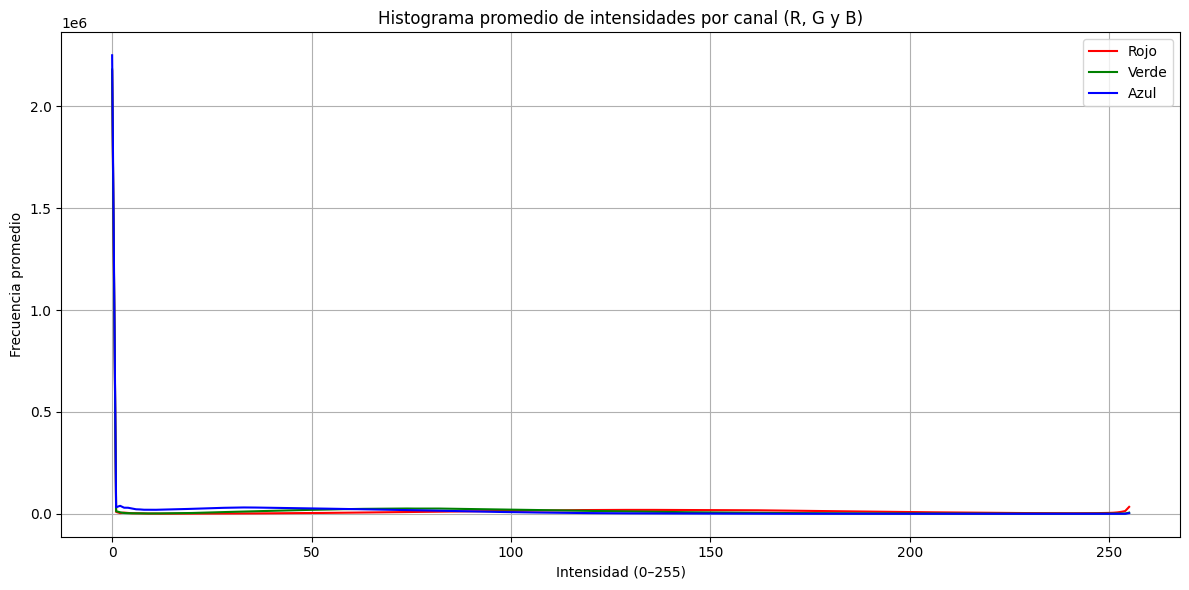

In [17]:
# visualización del histograma promedio de intensidades por canal RGB
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(image_r_hist, color='red', label='Rojo')

# Canal Verde
plt.plot(image_g_hist, color='green', label='Verde')

# Canal Azul
plt.plot(image_b_hist, color='blue', label='Azul')

plt.title("Histograma promedio de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Normalizamos los histogramas de color RGB para el conjunto de datos, de forma que las frecuencias se expresen en porcentaje. Luego, se grafican los histogramas normalizados a porcentaje para los canales Rojo, Verde y Azul, permitiendo ver visualmente la distribución de intensidades de color. 

In [18]:
# Funcióm para normalizar el histograma
def normalize_histogram_percent(hist):
    return hist / hist.sum() * 100  

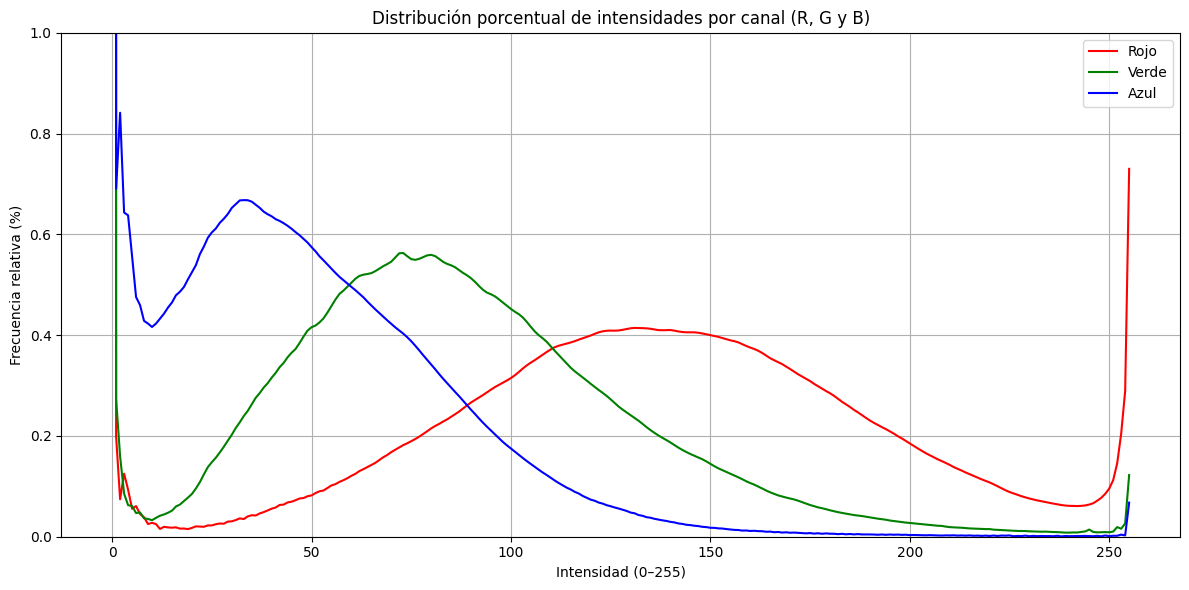

In [19]:
# Normalizamos todos los canales
r_hist_norm = normalize_histogram_percent(image_r_hist)
g_hist_norm = normalize_histogram_percent(image_g_hist)
b_hist_norm = normalize_histogram_percent(image_b_hist)

# Graficamos los histogramas normalizados
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(r_hist_norm, color='red', label='Rojo')

# Canal Verde
plt.plot(g_hist_norm, color='green', label='Verde')

# Canal Azul
plt.plot(b_hist_norm, color='blue', label='Azul')

plt.title("Distribución porcentual de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En los tres canales de color (R, G y B), se observa un pico de frecuencia cercano a la intensidad 0, lo que refleja una notable presencia del fondo negro en las imágenes. Esta característica podría inducir al modelo a aprender patrones asociados al fondo en lugar de centrarse en las regiones relevantes de la retina. Por este motivo, durante la fase de preprocesamiento se aplicarán técnicas orientadas a mitigar esta dependencia del fondo, con el fin de mejorar la robustez del modelo y reducir el riesgo de sobreajuste al ruido.

Además, se observa que el canal azul (B) presenta una menor variabilidad e intensidad relativa, lo que sugiere que podría aportar menos información diagnóstica útil en comparación con los canales rojo (R) y verde (G), que suelen ser más relevantes en la detección de lesiones retinianas como hemorragias o edemas.

A continuación, se realiza el análisis de imágenes oscuras y de bajo contraste, con el objetivo de identificar posibles deficiencias en la calidad visual que puedan afectar al rendimiento del modelo durante el entrenamiento.

In [20]:
# Umbrales (ajustables) los valores se han ajustado tras varias pruebas
DARK_THRESHOLD = 30  # Media de intensidad; por debajo de esto se considera oscura
LOW_CONTRAST_THRESHOLD = 35  # Desviación estándar; por debajo de esto es bajo contraste

def analyze_image_quality(image_path):
    """
    Evalúa si una imagen es oscura o de bajo contraste.

    Parámetros:
        image_path (str): Ruta al archivo de imagen.

    Devuelve:
        dict con:
            - 'is_dark': True si el brillo < DARK_THRESHOLD
            - 'is_low_contrast': True si el contraste < LOW_CONTRAST_THRESHOLD
            - 'brightness': Brillo medio (0–255)
            - 'contrast': Contraste (std)
            - 'hist': Histograma de grises (256 valores)
        o None si la imagen no puede leerse.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    brightness = np.mean(gray)
    contrast = np.std(gray)
  
    is_dark = brightness < DARK_THRESHOLD
    is_low_contrast = contrast < LOW_CONTRAST_THRESHOLD
    
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    
    return {
        'is_dark': is_dark,
        'is_low_contrast': is_low_contrast,
        'brightness': brightness,
        'contrast': contrast,
        'hist': hist
    }


In [21]:
def analyze_dataset(image_dir, sample_size=None):
    """
    Analiza el brillo y contraste de las imágenes en un directorio.

    Parámetros:
        image_dir (str): Ruta al directorio con imágenes .jpg.
        sample_size (int, opcional): Número de imágenes a analizar aleatoriamente.

    Devuelve:
        stats (dict): Estadísticas generales de calidad.
        results (list): Análisis por imagen (brillo, contraste, etc.).
    """
    image_paths = df['filename'].apply(lambda x: os.path.join(image_dir, x)).tolist()
    
    if sample_size:
        image_paths = random.sample(image_paths, sample_size)
    
    results = []
    dark_images = []
    low_contrast_images = []
    
    for path in tqdm(image_paths, desc="Analizando imágenes"):
        analysis = analyze_image_quality(path)
        if analysis:
            results.append(analysis)
            if analysis['is_dark']:
                dark_images.append(path)
            if analysis['is_low_contrast']:
                low_contrast_images.append(path)
    
    # Calcular estadísticas generales
    brightness_values = [r['brightness'] for r in results]
    contrast_values = [r['contrast'] for r in results]
    
    stats = {
        'total_images': len(results),
        'dark_images': len(dark_images),
        'low_contrast_images': len(low_contrast_images),
        'mean_brightness': np.mean(brightness_values),
        'mean_contrast': np.mean(contrast_values),
        'dark_image_paths': dark_images,
        'low_contrast_paths': low_contrast_images
    }
    
    return stats, results

Analizando imágenes: 100%|██████████| 6392/6392 [04:34<00:00, 23.25it/s]



=== ESTADÍSTICAS GENERALES ===
Total imágenes analizadas: 6392
Imágenes oscuras detectadas: 466 (7.3%)
Imágenes de bajo contraste detectadas: 771 (12.1%)
Brillo promedio: 54.5
Contraste promedio: 52.9


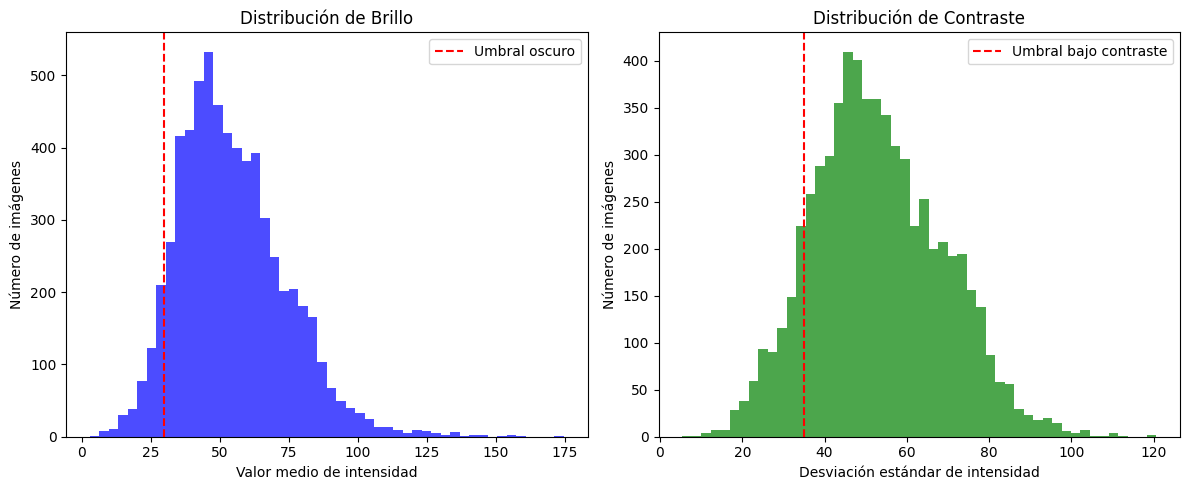

In [22]:
# Análisis del dataset
stats, individual_results = analyze_dataset(image_dir)

print("\n=== ESTADÍSTICAS GENERALES ===")
print(f"Total imágenes analizadas: {stats['total_images']}")
print(f"Imágenes oscuras detectadas: {stats['dark_images']} ({stats['dark_images']/stats['total_images']:.1%})")
print(f"Imágenes de bajo contraste detectadas: {stats['low_contrast_images']} ({stats['low_contrast_images']/stats['total_images']:.1%})")
print(f"Brillo promedio: {stats['mean_brightness']:.1f}")
print(f"Contraste promedio: {stats['mean_contrast']:.1f}")

# Visualizar distribución de brillo y contraste
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([r['brightness'] for r in individual_results], bins=50, color='blue', alpha=0.7)
plt.axvline(x=30, color='red', linestyle='--', label='Umbral oscuro')
plt.title('Distribución de Brillo')
plt.xlabel('Valor medio de intensidad')

plt.ylabel('Número de imágenes')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([r['contrast'] for r in individual_results], bins=50, color='green', alpha=0.7)
plt.axvline(x=35, color='red', linestyle='--', label='Umbral bajo contraste')
plt.title('Distribución de Contraste')
plt.xlabel('Desviación estándar de intensidad')
plt.ylabel('Número de imágenes')
plt.legend()

plt.tight_layout()
plt.show()

Parece que el contraste medio y el brillo son suficientemente altos, lo que habría que tener en cuenta para no aplicar transformaciones muy agresivas a todo el conjunto.

A continuación se realiza un análisis cuantitativo de calidad, mostrando ejemplos representativos de imágenes clasificadas como "oscuras" o de "bajo contraste". Esta revisión visual permite evaluar si los umbrales aplicados son adecuados y entender el impacto potencial en la capacidad del modelo para aprender características relevantes de la retina.


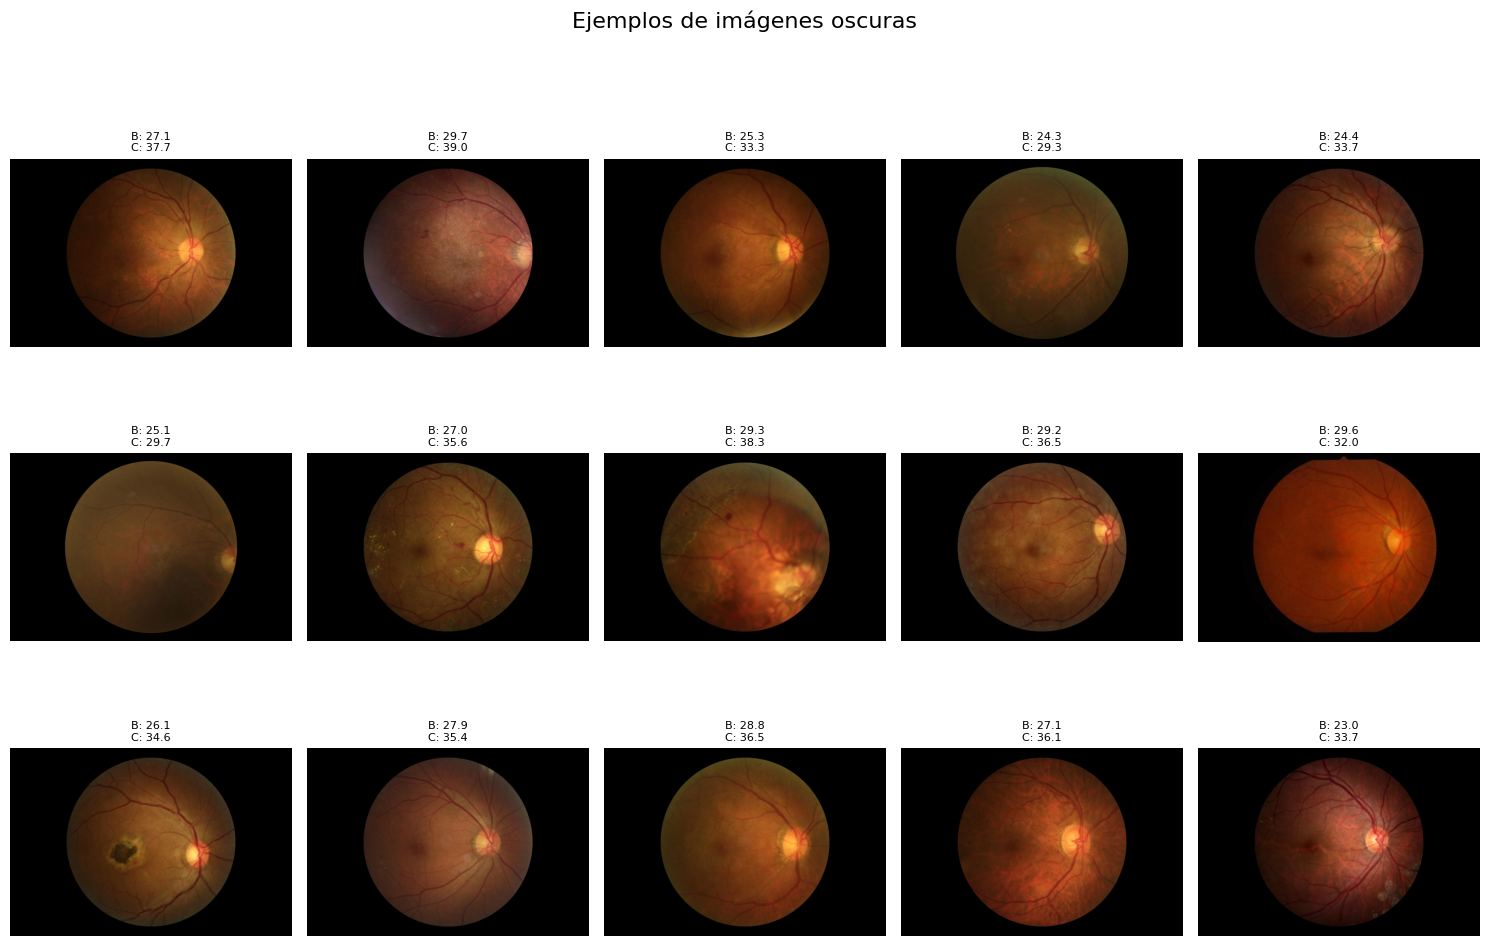

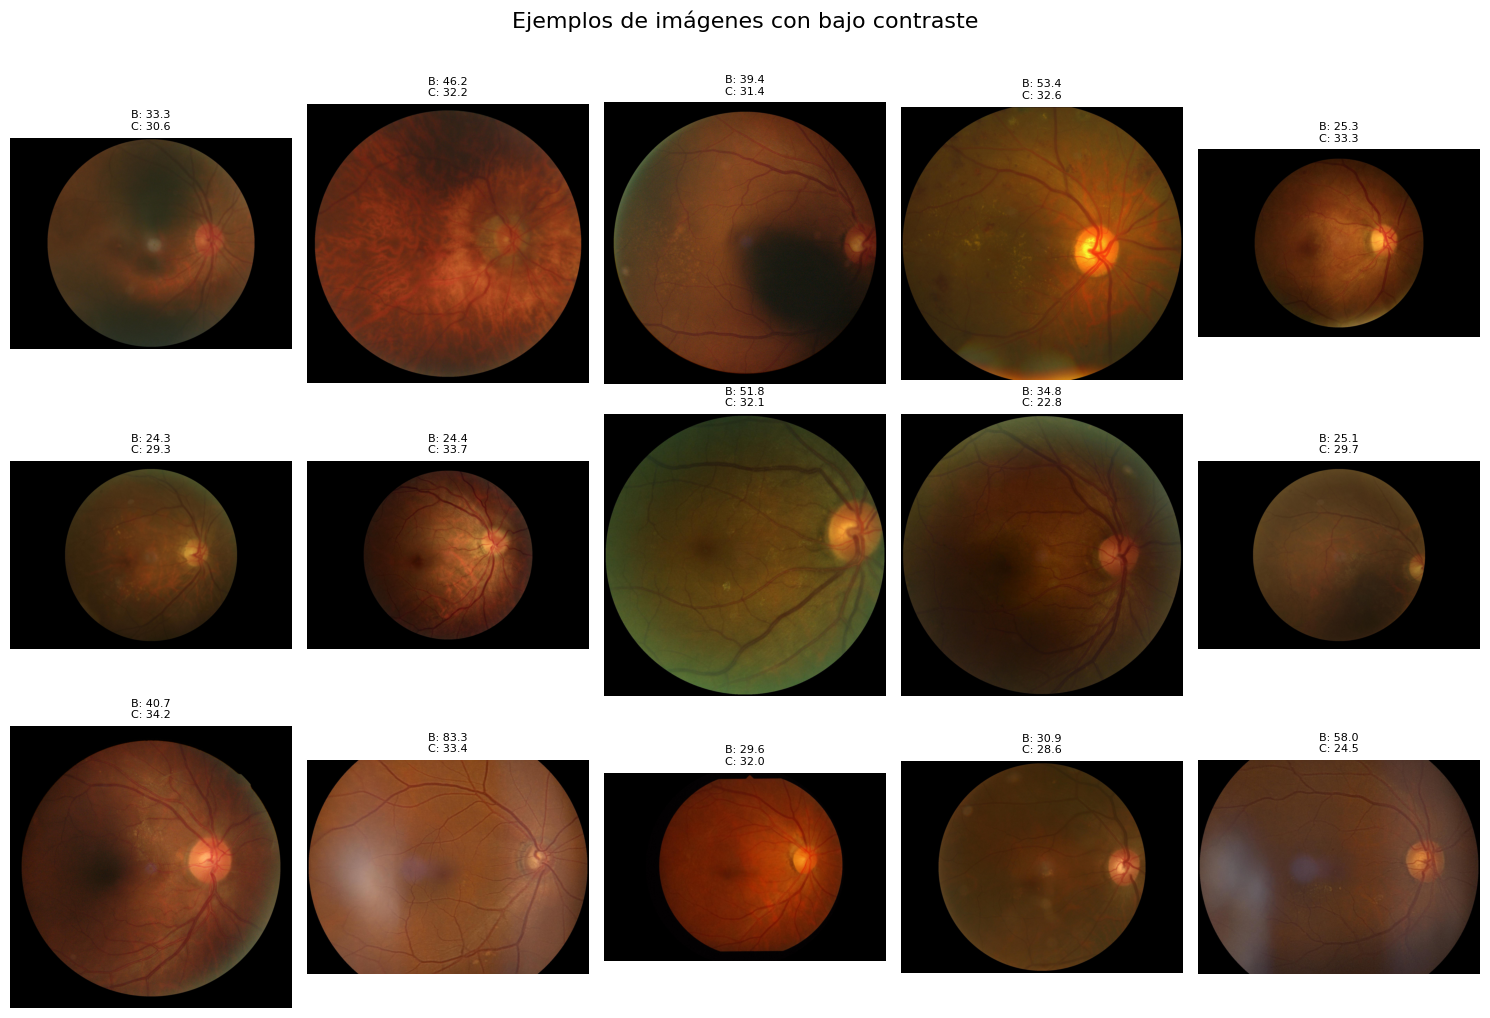

In [23]:
def display_quality_examples(image_path, title):
    """
    Evalúa la calidad de las imágenes (brillo y contraste) de un directorio.

    Parámetros:
        image_dir (str): Ruta base donde se encuentran las imágenes.
        sample_size (int, opcional): Número de imágenes a analizar aleatoriamente. Si None, analiza todas.

    Devuelve:
        stats (dict): Estadísticas generales del conjunto (medias, nº de imágenes oscuras/bajo contraste).
        results (list): Lista con el análisis individual de cada imagen.
    """
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, y=1.02, fontsize=16)
    
    for i, path in enumerate(image_path[:15]):
        plt.subplot(3, 5, i+1)
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        
        # Mostrar brillo y contraste en la imagen
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        plt.title(f"B: {brightness:.1f}\nC: {contrast:.1f}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Ejemplos de imágenes oscuras
if stats['dark_images'] > 0:
    display_quality_examples(stats['dark_image_paths'], "Ejemplos de imágenes oscuras")

# Ejemplos de imágenes con bajo contraste
if stats['low_contrast_images'] > 0:
    display_quality_examples(stats['low_contrast_paths'], "Ejemplos de imágenes con bajo contraste")

### Distribución de las imágenes oscuras y bajo contraste por Clase diagnóstica

En esta sección se analiza cómo se distribuyen las imágenes oscuras y con bajo contraste entre las diferentes clases diagnósticas. Esto permite identificar si ciertas patologías están asociadas con una mayor frecuencia de imágenes de baja calidad, lo cual podría influir en el rendimiento del modelo y requerir estrategias específicas de preprocesamiento.

In [24]:
# Crear DataFrame de calidad de imágen 
quality_data = []
for idx, row in df.iterrows():
    img_path = os.path.join(image_dir, row['filename'])
    analysis = analyze_image_quality(img_path)
    if analysis:
        quality_data.append({
            'filename': row['filename'],
            'brightness': analysis['brightness'],
            'contrast': analysis['contrast'],
            'is_dark': analysis['is_dark'],
            'is_low_contrast': analysis['is_low_contrast'],
            'labels': row['labels'] 
        })

quality_df = pd.DataFrame(quality_data)

labels_expanded = quality_df['labels'].apply(lambda x: ''.join(eval(x)) if isinstance(x, str) else ''.join(x)).str.get_dummies()
quality_df = pd.concat([quality_df.drop('labels', axis=1), labels_expanded], axis=1)

In [25]:
quality_df.head(10)

filename  brightness   contrast  is_dark  is_low_contrast  A  C  D  G  \
0   0_right.jpg   33.274280  30.609474    False             True  0  0  0  0   
1   1_right.jpg   53.834958  65.333838    False            False  0  0  0  0   
2   2_right.jpg   34.812584  35.673807    False            False  0  0  1  0   
3   4_right.jpg   50.609196  64.242010    False            False  0  0  1  0   
4   5_right.jpg   71.283488  57.147460    False            False  0  0  1  0   
5   6_right.jpg   64.874773  78.432210    False            False  0  0  1  0   
6   7_right.jpg   59.500859  73.326004    False            False  0  0  1  0   
7   8_right.jpg   73.012502  49.007796    False            False  0  0  0  0   
8   9_right.jpg   68.673310  67.442972    False            False  0  0  0  0   
9  10_right.jpg   92.300277  54.847547    False            False  0  0  0  0   

   H  M  N  O  
0  0  0  1  0  
1  0  0  1  0  
2  0  0  0  0  
3  0  0  0  0  
4  0  0  0  0  
5  0  0  0  0  
6  0  0  0  0  
7  0  0  1  0  
8  0  0  0  1  
9  0  0  1  0

/var/folders/7z/6sq72d5x0s948s3fwhhpbthh0000gn/T/ipykernel_2425/4206853448.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease', y='% Dark', data=pct_dark_df, palette='viridis')


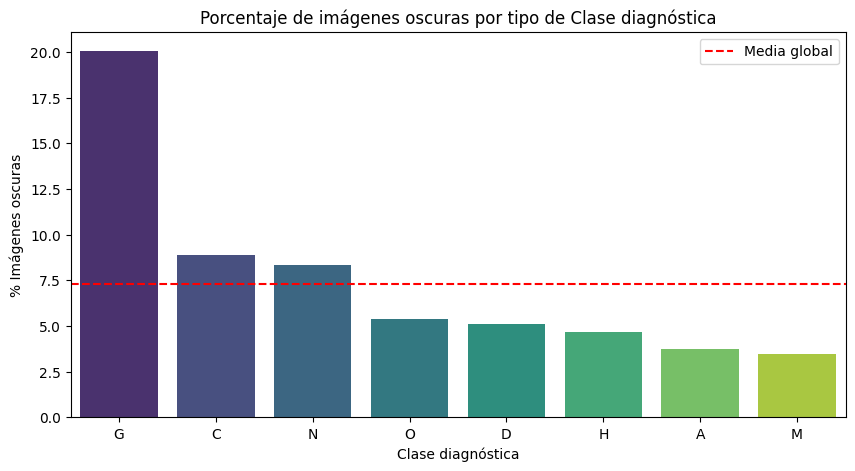

In [26]:
# Lista de Clases diagnósticas
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Calcular % de imágenes oscuras por Clase diagnóstica
results = []
for disease in diseases:
    total = quality_df[disease].sum()
    dark = quality_df[(quality_df[disease] == 1) & (quality_df['is_dark'])].shape[0]
    pct = (dark / total) * 100 if total > 0 else 0
    results.append({'Disease': disease, 'Total': total, 'Dark': dark, '% Dark': pct})

pct_dark_df = pd.DataFrame(results).sort_values('% Dark', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='% Dark', data=pct_dark_df, palette='viridis')
plt.title('Porcentaje de imágenes oscuras por tipo de Clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes oscuras')
plt.axhline(y=quality_df['is_dark'].mean() * 100, color='red', linestyle='--', 
            label='Media global')
plt.legend()
plt.show()

En la gráfica anterior se observa que un porcentaje elevado de imágenes oscuras pertenece a la clase "Glaucoma", lo que sugiere que sería más adecuado intentar corregir su calidad mediante técnicas de mejora de imagen, en lugar de eliminarlas del conjunto de datos.

Además, las clases "Cataratas" (C) y "Fondo normal" (N) también presentan un porcentaje de imágenes oscuras ligeramente por encima de la media global, lo cual podría afectar al modelo y que no generalice bien.

Para el resto de clases, el número de imágenes oscuras es significativamente menor, por lo que el impacto potencial sobre el entrenamiento es menor.

/var/folders/7z/6sq72d5x0s948s3fwhhpbthh0000gn/T/ipykernel_2425/929582487.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease', y='% Low Contrast', data=pct_low_contrast_df, palette='crest')


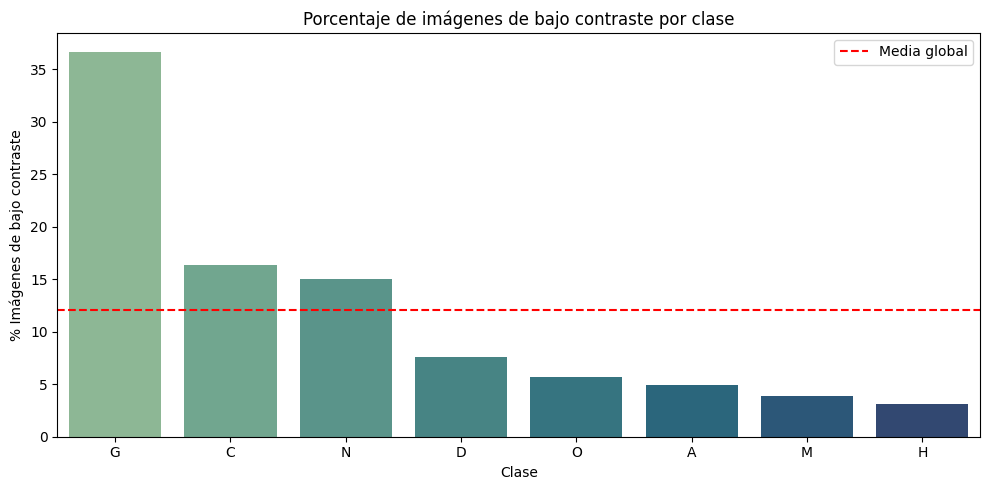

In [27]:
# Calcular % de imágenes de bajo contraste por Clase diagnóstica
results_contrast = []
for disease in diseases:
    total = quality_df[disease].sum()
    low_contrast = quality_df[(quality_df[disease] == 1) & (quality_df['is_low_contrast'])].shape[0]
    pct = (low_contrast / total) * 100 if total > 0 else 0
    results_contrast.append({'Disease': disease, 'Total': total, 'Low Contrast': low_contrast, '% Low Contrast': pct})

# Crear DataFrame ordenado por % bajo contraste
pct_low_contrast_df = pd.DataFrame(results_contrast).sort_values('% Low Contrast', ascending=False)

# Gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='% Low Contrast', data=pct_low_contrast_df, palette='crest')
plt.title('Porcentaje de imágenes de bajo contraste por clase')
plt.xlabel('Clase')
plt.ylabel('% Imágenes de bajo contraste')
plt.axhline(y=quality_df['is_low_contrast'].mean() * 100, color='red', linestyle='--', 
            label='Media global')
plt.legend()
plt.tight_layout()
plt.show()

Se observa nuevamente que la mayoría de las imágenes con bajo contraste corresponden a la clase "Glaucoma", y para las clases "Cataratas" (C) y "Fondo normal" (N) también un porcentaje superior a la media global.

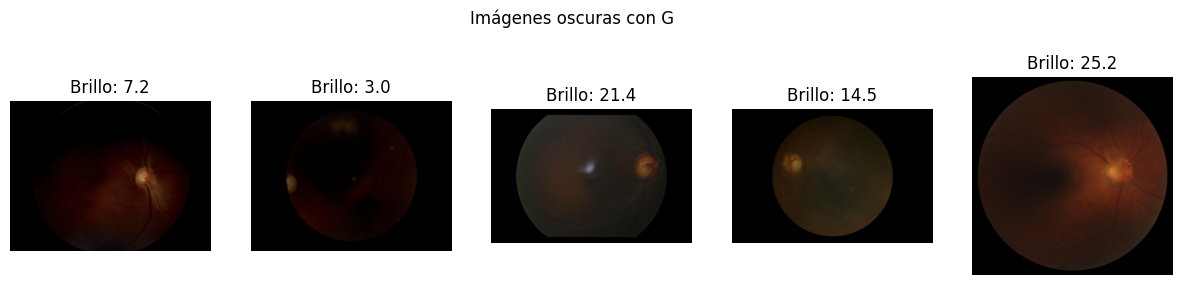

In [28]:
def plot_dark_images_by_disease(disease, n_samples=5):
    """
    Muestra ejemplos de imágenes oscuras pertenecientes a una clase diagnóstica específica.

    Parámetros:
        disease (str): Código de la enfermedad (por ejemplo, 'G' para glaucoma).
        n_samples (int): Número de imágenes oscuras a visualizar (por defecto 5).
    """
    dark_samples = quality_df[(quality_df[disease] == 1) & 
                            (quality_df['is_dark'])].sample(n_samples)
    
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(dark_samples.iterrows()):
        img = cv2.imread(os.path.join(image_dir, row['filename']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"Brillo: {row['brightness']:.1f}")
        plt.axis('off')
    plt.suptitle(f'Imágenes oscuras con {disease}', y=1.05)
    plt.show()

# Ejemplo para clase Glaucoma ('G')
plot_dark_images_by_disease('G')

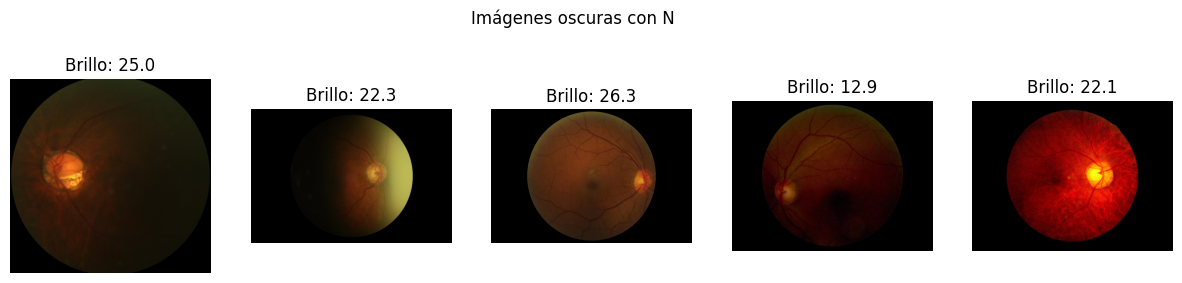

In [29]:
# Ejemplo para clase Normal ('N')
plot_dark_images_by_disease('N')

In [30]:
# Tabla informativa de calidad visual por clase diagnóstica
tabla_calidad = pct_dark_df.merge(
    pct_low_contrast_df,
    on='Disease',
    suffixes=('_dark', '_low_contrast')
)

tabla_calidad = tabla_calidad.rename(columns={
    'Disease': 'Clase diagnóstica',
    'Total_dark': 'Total imágenes',
    'Dark': 'Imágenes oscuras',
    '% Dark': '% oscuras',
    'Low Contrast': 'Imágenes bajo contraste',
    '% Low Contrast': '% bajo contraste'
})

tabla_calidad = tabla_calidad[[
    'Clase diagnóstica',
    'Total imágenes',
    'Imágenes oscuras',
    '% oscuras',
    'Imágenes bajo contraste',
    '% bajo contraste'
]]

# Mostrar tabla final
display(tabla_calidad)

Clase diagnóstica  Total imágenes  Imágenes oscuras  % oscuras  \
0                 G             284                57  20.070423   
1                 C             293                26   8.873720   
2                 N            2873               239   8.318830   
3                 O             708                38   5.367232   
4                 D            1608                82   5.099502   
5                 H             128                 6   4.687500   
6                 A             266                10   3.759398   
7                 M             232                 8   3.448276   

   Imágenes bajo contraste  % bajo contraste  
0                      104         36.619718  
1                       48         16.382253  
2                      431         15.001740  
3                       40          5.649718  
4                      122          7.587065  
5                        4          3.125000  
6                       13          4.887218  
7                        9          3.879310

La clase G (Glaucoma) sería la que presenta menor calidad visual: el 20 % de sus imágenes son oscuras y el 36,6 % presentan bajo contraste, lo que podría dificultar la correcta identificación de esta patología durante el entrenamiento del modelo. También se observan valores superiores a la media en las clases C (Catarata) y N (Fondo normal), con un 8–9 % de imágenes oscuras y más de un 15 % con bajo contraste.

El resto de clases mantiene porcentajes bajos en ambas métricas (por debajo del 8 % en general), lo que indica una mejor calidad global en esas categorías.

Hay que tener en cuenta ese desequilibrio en la calidad, ya que podría ser necesario aplicar estrategias de preprocesado específicas por clase, como `CLAHE` o `ColorJitter (brightness, contrast)`, especialmente para Glaucoma, antes de descartar imágenes potencialmente útiles. 

A continuación mostramos un boxplot que muestra la distribución del brillo de las imágenes según la presencia o ausencia de cada enfermedad. los colores diferencia si la imagen tiene o no la enfermedad (1: la tiene, o: no la tiene).

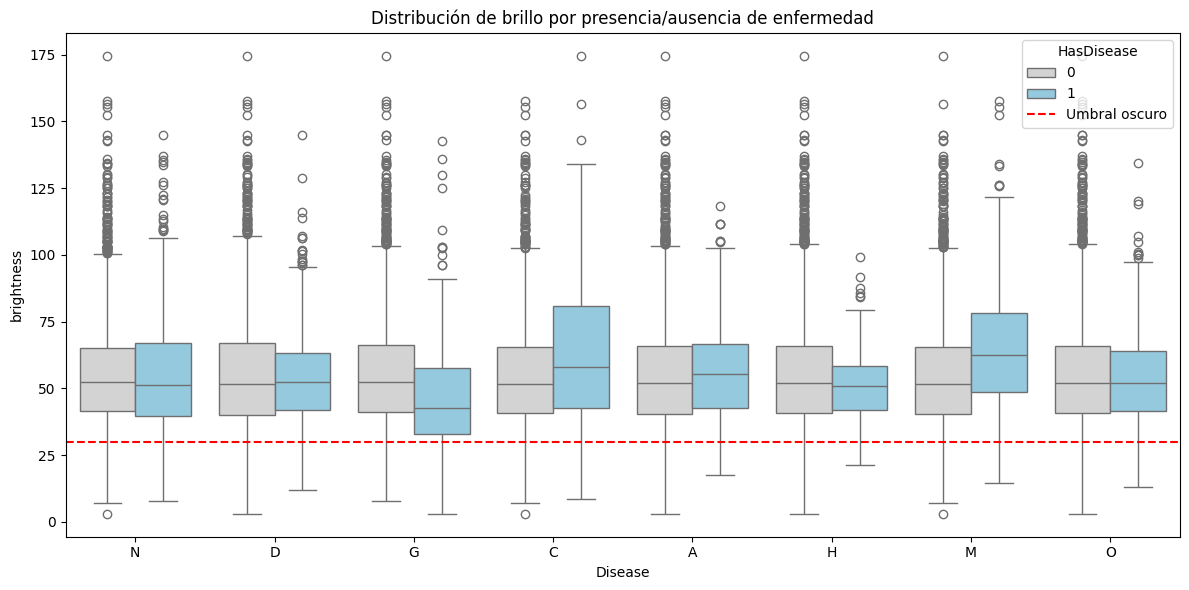

In [31]:
# Visualización de la distribución de brillo por presencia/ausencia de enfermedad
plot_df = quality_df.melt(
    id_vars=['brightness'],
    value_vars=diseases,
    var_name='Disease',
    value_name='HasDisease'
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df,
    x='Disease',
    y='brightness',
    hue='HasDisease',
    palette={0: 'lightgray', 1: 'skyblue'}
)
plt.title('Distribución de brillo por presencia/ausencia de enfermedad')
plt.axhline(y=DARK_THRESHOLD, color='red', linestyle='--', label='Umbral oscuro')
plt.legend(title='HasDisease')
plt.tight_layout()
plt.show()

Aplicamos un test estadístico (t-test independiente) para comparar si hay diferencias significativas en el brillo medio entre imágenes con y sin cada una de las enfermedadades.

In [32]:
# Comparación de brillo entre grupos con y sin enfermedad
def compare_brightness_simple(quality_df, diseases):
    """
    Para cada columna de enfermedad (0/1), compara el brillo entre grupos:
    - group1: filas con enfermedad == 1
    - group0: filas con enfermedad == 0
    Utiliza la prueba t de Welch (equal_var=False).
    Devuelve un DataFrame resumen.
    """
    rows = []
    for d in diseases:
        g1 = quality_df.loc[quality_df[d] == 1, 'brightness'].dropna()
        g0 = quality_df.loc[quality_df[d] == 0, 'brightness'].dropna()
        t_stat, p_val = ttest_ind(g1, g0, equal_var=False)
        rows.append({
            'disease': d,
            'n_with': len(g1),
            'n_without': len(g0),
            'mean_brightness_with': g1.mean(),
            'mean_brightness_without': g0.mean(),
            'mean_diff': g1.mean() - g0.mean(),
            'p_value': p_val
        })
    out = pd.DataFrame(rows).sort_values('p_value').reset_index(drop=True)
    return out

brightness_summary = compare_brightness_simple(quality_df, diseases)
brightness_summary

disease  n_with  n_without  mean_brightness_with  mean_brightness_without  \
0       M     232       6160             65.889023                54.066037   
1       G     284       6108             46.797581                54.853066   
2       C     293       6099             62.780021                54.097146   
3       N    2873       3519             53.850602                55.021386   
4       H     128       6264             51.585135                54.554620   
5       A     266       6126             56.599459                54.403784   
6       D    1608       4784             53.821767                54.721496   
7       O     708       5684             54.301118                54.519326   

   mean_diff       p_value  
0  11.822986  4.130288e-12  
1  -8.055484  3.614651e-09  
2   8.682876  4.744749e-07  
3  -1.170784  1.641094e-02  
4  -2.969485  2.084773e-02  
5   2.195675  6.107776e-02  
6  -0.899729  7.180914e-02  
7  -0.218208  7.572183e-01

Perece que hay evidencia estadística de que algunas enfermedades se asocian con diferencias en el brillo medio:

Imágenes de pacientes con glaucoma son significativamente más oscuras, mientras que las de paciente de cataratas o miopía son significativamente más claras.


En esta sección se visualizan los valores medios de brillo y contraste por clase diagnóstica mediante un mapa de calor. Esta representación permite identificar de forma rápida si existen patrones sistemáticos de calidad visual (imágenes más oscuras o con menor contraste) asociados a determinadas enfermedades

In [33]:
# Lista de clases del dataset
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Crear una tabla con brillo y contraste medios por clase
heatmap_data = []

for disease in diseases:
    subset = quality_df[quality_df[disease] == 1]
    heatmap_data.append([
        disease,
        subset['brightness'].mean(),
        subset['contrast'].mean()
    ])

# Convertimos a DataFrame
heatmap_df = pd.DataFrame(heatmap_data, columns=['Disease', 'Brightness', 'Contrast'])
heatmap_df.set_index('Disease', inplace=True)

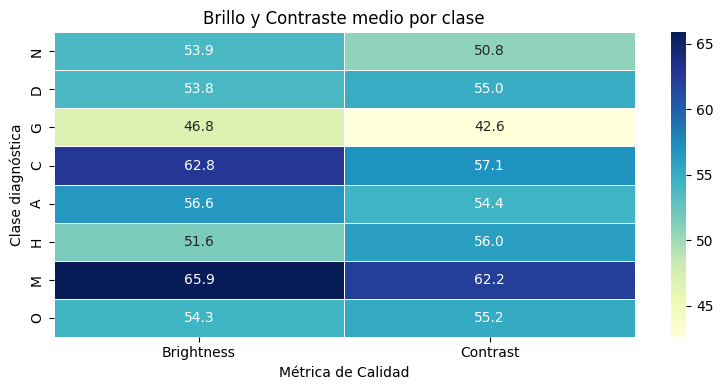

In [34]:
# Graficamos el heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5)
plt.title("Brillo y Contraste medio por clase")
plt.ylabel("Clase diagnóstica")
plt.xlabel("Métrica de Calidad")
plt.tight_layout()
plt.show()

## Propuestas a valorar para la transformación de imágenes, creación de Dataloader y arquitectura

### 1. Posible eliminación de las imágenes consideradas oscuras 

- Total afectado: **620 imágenes** (~**7,8%** del total).
- Recomendación: **no eliminar directamente** si el porcentaje de imágenes oscuras se concentra en una clase concreta (por ejemplo, la clase 'G' de glaucoma), ya que podríamos introducir un sesgo.
- Alternativas:
  - Aplicar transformaciones como `ColorJitter(brightness)` para mejorar el brillo.
  - Usar `sample_weight` para reducir su influencia en el entrenamiento en lugar de eliminarlas.

---

### 2. Mejora mediante ecualización CLAHE

_Aplicable sobre el dataset completo o solo sobre imágenes de bajo contraste._

**Ventajas:**
- Mejora la visibilidad de características poco evidentes como **microaneurismas, exudados o neovasos**.
- Ajusta el contraste local por zonas.
- Puede mejorar también el brillo (aunque en general ya se encuentra en valores aceptables).

**Desventajas:**
- Puede aumentar el ruido visual y producir falsos positivos.
- Requiere ajuste de parámetros como el *clip limit*.
- Su efecto puede ser limitado sin segmentación previa.
- No siempre mejora el rendimiento del modelo.

---

### 3. Tamaño de redimensionamiento de las imágenes

- El tamaño más frecuente es **(1728, 2592, 3)** → **~30% del total**.

**Consideraciones:**

- **Redimensionar a ese tamaño no es recomendable**:
  - Muy costoso computacionalmente.
  - Puede forzar al modelo a aprender detalles irrelevantes y sobreajustar.

- **Alternativas realistas**:
  - `1024 x 1024`: Fine-tuning en modelos propios.
  - `896 x 1344`: Proporción ≈ 2:3, útil si se entrena desde cero.
  - **Tamaños redes pre-entrenada**:
    - `224×224` → ResNet18, MobileNet
    - `380×380` → EfficientNet-B4

> Importante: **Definir primero la arquitectura** y luego adaptar el tamaño. Alinear ambos para evitar incompatibilidades o pérdida de detalle.

---

### 4. Tipo de redimensionamiento

Comparativa de métodos:

- **`cv2.resize`**:
  - Redimensionamiento directo.
  - Puede **deformar** la imagen → No recomendable.

- **Resize + padding**:
  - Ajusta sin deformar.
  - Introduce **bordes artificiales** → ruido visual.

- **`transforms.Resize` + `CenterCrop`**:
  - Mantiene la proporción.
  - Preserva la región central sin relleno artificial.
  - Preferible para preservar la forma y estructura anatómica.

---

### 5. Simetría de las imágenes

- Asegurar que las imágenes de ojo izquierdo y derecho estén correctamente orientadas.
- Aplicar `RandomHorizontalFlip()` y `RandomRotation()`como técnicas de aumento para prevenir el sobreajuste direccional y mejorar la robustez del modelo.

---

### 6. Aumento cromático (ColorJitter)

- Dado que un **12% de imágenes tiene bajo contraste**, se podría aplicar `ColorJitter(contrast, saturation)` con moderación o solo a ls imágenes identificadas de bajo contraste.
- Riesgo: **colores artificiales no representativos** si se abusa.

---

### 7. Balanceo de clases

Opciones recomendadas:

- `WeightedRandomSampler` en el `DataLoader`.
- Pérdida ponderada (`class_weight` en PyTorch o Sklearn).
- Oversampling de clases minoritarias.

---

### 8. Normalización por canal RGB

- Tener en cuenta que alunos modelos preentrenados (ResNet, EfficientNet) requieren normalización de las imágenes.
